In [1]:
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from sklearn.svm import SVC

In [2]:
# Pre-processing: rid of all columns that are mostly unfilled and patients who declined to answer a question
cerv_data = pd.read_csv('risk_factors_cervical_cancer.csv', na_values=["?"])
print(len(cerv_data.columns))
cerv_data = cerv_data.drop(columns =['STDs: Time since last diagnosis','STDs: Time since first diagnosis'])
cerv_data = cerv_data.dropna()
#print(cerv_data)
x, y = cerv_data.iloc[:,:-4], cerv_data.iloc[:,-4:]
# print(x)
# print(y)

36


In [3]:
# Confusion matrix utilities
from IPython.display import HTML

def print_confusion(cm):
    column_names = pd.DataFrame([['Predicted', '-'],
                                 ['Predicted', '+']],
                                 columns=['', ''])
    row_names = pd.DataFrame([['Observed', '-'],
                              ['Observed', '+']],
                              columns=['', ''])
    columns = pd.MultiIndex.from_frame(column_names)
    index = pd.MultiIndex.from_frame(row_names)
    display(pd.DataFrame(cm, index=index, columns=columns))

def get_score(cm):
    return (cm[0,0]+cm[1,1])/np.sum(cm)

def get_fp_rate(cm):
    return cm[0,1]/(cm[0,0]+cm[0,1])

def get_fn_rate(cm):
    return cm[1,0]/(cm[1,1]+cm[1,0])

def get_f1_score(cm):
    TP = cm[1,0]+cm[1,1]
    return TP/(TP+.5*(cm[1,0]+cm[0,1]))

def misclassification(cm):
    return (cm[0,1]+cm[1,0])/(cm[1,0]+cm[0,1]+cm[0,0]+cm[1,1])

def display_model_stats(cm, name):
    display(HTML('''
        <div class="row">
        <style scoped>
            tr th {{
                font-weight: 600;
                text-align: center;
            }}
            thead th {{
                font-weight: bold;
                text-align: center;
            }}
            .rotate {{
                transform: rotate(-180deg);
                writing-mode: vertical-rl;
                margin: 0em;
            }}
            .row {{ display: flex; }}
            .column {{ padding: 5px; }}
        </style>
        <div class="column">
            <table>
            <thead>
                <th colspan="4">{0}</th>
            </thead>
            <tr>
                <td rowspan="2" colspan="2"></td>
                <th colspan="2">Predicted</th>
            </tr>
            <tr>
                <th>-</td>
                <th>+</td>
            </tr>
            <tr>
                <th rowspan="2"><p class="rotate">Observed</p></th>
                <th>-</td>
                <td>{1}</td>
                <td>{2}</td>
            </tr>
            <tr>
                <th>+</td>
                <td>{3}</td>
                <td>{4}</td>
            </tr>
            </table>
        </div>
        <div class="column">
            <table>
            <thead>
                <th colspan="2">{0}</th>
            </thead>
            <tr>
                <th>Total accuracy</th>
                <td>{5:.3}</td>
            </tr>
            <tr>
                <th>False positive rate</th>
                <td>{6:.3}</td>
            </tr>
            <tr>
                <th>False negative rate</th>
                <td>{7:.3}</td>
            </tr>
            </table>
        </div>
        </div>
    '''.format(
        name,
        cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1],
        get_score(cm), get_fp_rate(cm), get_fn_rate(cm)
    )))

In [4]:
###### Logistic regression ######
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.utils import compute_sample_weight
from sklearn.metrics import confusion_matrix

hinselmann, schiller, citology, biopsy = y.loc[:, 'Hinselmann'], y.loc[:, 'Schiller'], y.loc[:, 'Citology'], y.loc[:, 'Biopsy']

lr_pipe = Pipeline([('scale', StandardScaler()), ('logreg', LogisticRegression())])

# Direct fitting
def direct_fit_classifier(pipe, x, y, balanced_step_name=None):
    if balanced_step_name:
        fit_params = {'{0}__sample_weight'.format(balanced_step_name): compute_sample_weight('balanced', y)}
    else:
        fit_params = {}
    pipe.fit(x, y, **fit_params)
    return confusion_matrix(y, pipe.predict(x))

# Cross-validation
def cv_classifier(pipe, x, y, cv, balanced_step_name=None):
    ypred = np.empty(x.shape[0])
    for train_i, test_i in cv.split(x):
        if balanced_step_name:
            fit_params = {'{0}__sample_weight'.format(balanced_step_name): compute_sample_weight('balanced', y.iloc[train_i])}
        else:
            fit_params = {}
        pipe.fit(x.iloc[train_i], y.iloc[train_i], **fit_params)
        ypred[test_i] = pipe.predict(x.iloc[test_i])
    return confusion_matrix(y, ypred)

for outcome, name in zip([hinselmann, schiller, citology, biopsy],
                         ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']):
    direct_cm = direct_fit_classifier(lr_pipe, x, outcome, 'logreg')
    cv_cm = cv_classifier(lr_pipe, x, outcome, KFold(shuffle=True), 'logreg')

    display_model_stats(direct_cm, '{0} upon fitting'.format(name))
    display_model_stats(cv_cm, '{0} upon CV'.format(name))

In [5]:
###### Support vector machines ######
#we will have to play with c value and kernel
svc_model = Pipeline([('scale', StandardScaler()), ('svm', SVC(C=1000, kernel='rbf'))])
hinselmann_arr = np.array(hinselmann)
svc_model.fit(x, hinselmann_arr)
hinselmann_predict = svc_model.predict(x)
#print(hinselmann_predict)
print(cv_classifier(svc_model, x, hinselmann, KFold()))

schiller_arr = np.array(schiller)
svc_model.fit(x, schiller_arr)
schiller_predict = svc_model.predict(x)
#print(schiller_predict)
print(cv_classifier(svc_model, x, schiller, KFold()))

citology_arr = np.array(citology)
svc_model.fit(x, citology_arr)
citology_predict = svc_model.predict(x)
#print(citology_predict)
print(cv_classifier(svc_model, x, citology, KFold()))

biopsy_arr = np.array(biopsy)
svc_model.fit(x, biopsy_arr)
biopsy_predict = svc_model.predict(x)
#print(biopsy_predict)
print(cv_classifier(svc_model, x, biopsy, KFold()))


[[627  11]
 [ 27   3]]
[[573  32]
 [ 51  12]]
[[603  26]
 [ 35   4]]
[[597  26]
 [ 36   9]]


In [6]:
tests = [hinselmann, schiller, citology, biopsy]
kernels_options = ['rbf', 'poly']
cv_data = np.zeros((4,2,20))
cv_FN = np.zeros((4,2,20))
cv_FP = np.zeros((4,2,20))
cv_f1 = np.zeros((4,2,20))
cv_mis = np.zeros((4,2,20))
c_values = np.logspace(-4,5,20)
for a in range(4):
    for i, b in enumerate(c_values):
        for c in range(2):
            svc_model = Pipeline([('scale', StandardScaler()), ('svm', SVC(C=b, kernel=kernels_options[c]))])
            direct_cm = direct_fit_classifier(svc_model, x, tests[a])
            cv_cm = cv_classifier(svc_model, x, tests[a], KFold())
            display_model_stats(direct_cm, '{0} upon fitting'.format(name))
            display_model_stats(cv_cm, '{0} upon CV'.format(name))
            cv_data[a,c,i] = get_score(cv_cm)
            cv_FN[a,c,i] = get_fn_rate(cv_cm)
            cv_FP[a,c,i] = get_fp_rate(cv_cm)
            cv_f1[a,c,i] = get_f1_score(cv_cm)
            cv_mis[a,c,i] = misclassification(cv_cm)
            print(tests[a])
            print(kernels_options[c])
            print(c_values[i])
    

0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.0001


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.0001


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.00029763514416313193


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.00029763514416313193


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.0008858667904100823


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.0008858667904100823


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.0026366508987303583


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.0026366508987303583


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.007847599703514606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.007847599703514606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.023357214690901212


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.023357214690901212


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.06951927961775606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.06951927961775606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.2069138081114788


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.2069138081114788


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
0.615848211066026


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
0.615848211066026


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
1.8329807108324339


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
1.8329807108324339


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
5.455594781168514


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
5.455594781168514


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
16.23776739188721


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
16.23776739188721


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
48.32930238571752


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
48.32930238571752


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
143.8449888287663


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
143.8449888287663


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
428.1332398719387


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
428.1332398719387


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
1274.2749857031322


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
1274.2749857031322


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
3792.690190732246


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
3792.690190732246


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
11288.378916846883


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
11288.378916846883


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
33598.18286283774


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
33598.18286283774


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
rbf
100000.0


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Hinselmann, Length: 668, dtype: int64
poly
100000.0


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.0001


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.0001


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.00029763514416313193


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.00029763514416313193


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.0008858667904100823


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.0008858667904100823


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.0026366508987303583


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.0026366508987303583


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.007847599703514606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.007847599703514606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.023357214690901212


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.023357214690901212


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.06951927961775606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.06951927961775606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.2069138081114788


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.2069138081114788


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
0.615848211066026


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
0.615848211066026


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
1.8329807108324339


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
1.8329807108324339


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
5.455594781168514


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
5.455594781168514


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
16.23776739188721


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
16.23776739188721


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
48.32930238571752


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
48.32930238571752


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
143.8449888287663


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
143.8449888287663


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
428.1332398719387


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
428.1332398719387


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
1274.2749857031322


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
1274.2749857031322


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
3792.690190732246


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
3792.690190732246


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
11288.378916846883


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
11288.378916846883


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
33598.18286283774


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
33598.18286283774


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
rbf
100000.0


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Schiller, Length: 668, dtype: int64
poly
100000.0


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.0001


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.0001


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.00029763514416313193


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.00029763514416313193


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.0008858667904100823


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.0008858667904100823


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.0026366508987303583


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.0026366508987303583


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.007847599703514606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.007847599703514606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.023357214690901212


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.023357214690901212


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.06951927961775606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.06951927961775606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.2069138081114788


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.2069138081114788


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
0.615848211066026


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
0.615848211066026


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
1.8329807108324339


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
1.8329807108324339


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
5.455594781168514


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
5.455594781168514


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
16.23776739188721


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
16.23776739188721


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
48.32930238571752


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
48.32930238571752


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
143.8449888287663


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
143.8449888287663


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
428.1332398719387


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
428.1332398719387


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
1274.2749857031322


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
1274.2749857031322


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
3792.690190732246


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
3792.690190732246


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
11288.378916846883


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
11288.378916846883


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
33598.18286283774


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
33598.18286283774


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
rbf
100000.0


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    1
856    0
857    0
Name: Citology, Length: 668, dtype: int64
poly
100000.0


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.0001


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.0001


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.00029763514416313193


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.00029763514416313193


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.0008858667904100823


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.0008858667904100823


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.0026366508987303583


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.0026366508987303583


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.007847599703514606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.007847599703514606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.023357214690901212


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.023357214690901212


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.06951927961775606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.06951927961775606


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.2069138081114788


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.2069138081114788


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
0.615848211066026


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
0.615848211066026


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
1.8329807108324339


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
1.8329807108324339


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
5.455594781168514


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
5.455594781168514


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
16.23776739188721


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
16.23776739188721


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
48.32930238571752


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
48.32930238571752


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
143.8449888287663


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
143.8449888287663


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
428.1332398719387


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
428.1332398719387


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
1274.2749857031322


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
1274.2749857031322


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
3792.690190732246


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
3792.690190732246


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
11288.378916846883


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
11288.378916846883


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
33598.18286283774


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
33598.18286283774


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
rbf
100000.0


0      0
1      0
3      0
4      0
5      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 668, dtype: int64
poly
100000.0


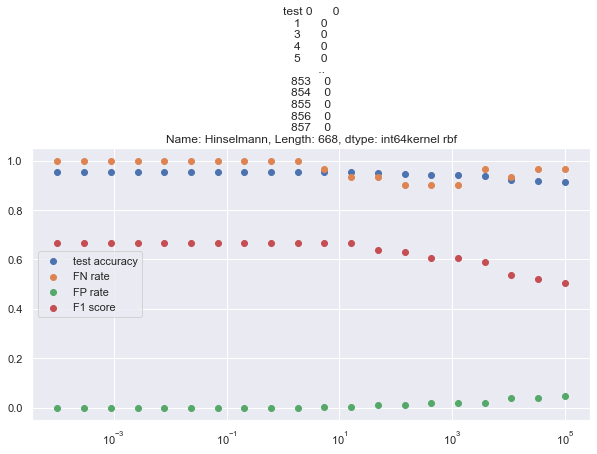

0.6666666666666666
0.04491017964071856


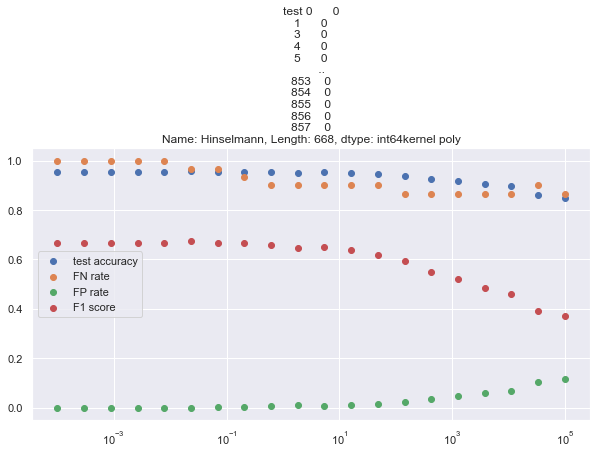

0.6741573033707865
0.04341317365269461


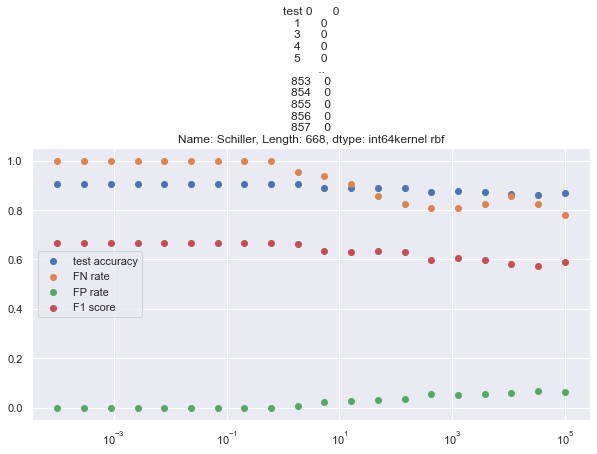

0.6666666666666666
0.09431137724550898


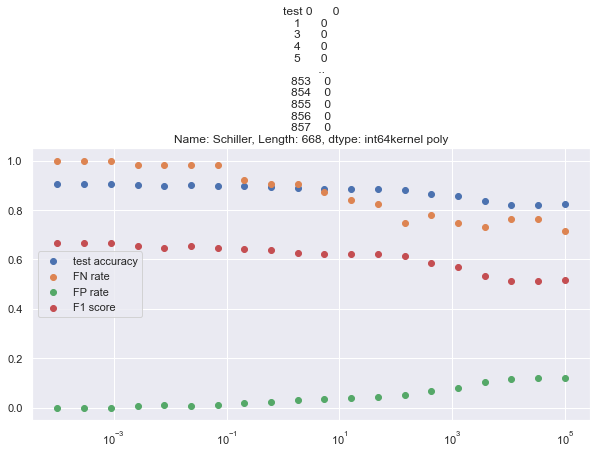

0.6666666666666666
0.09431137724550898


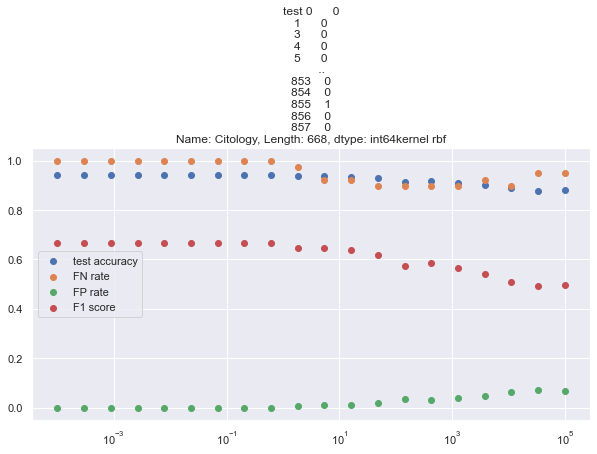

0.6666666666666666
0.058383233532934134


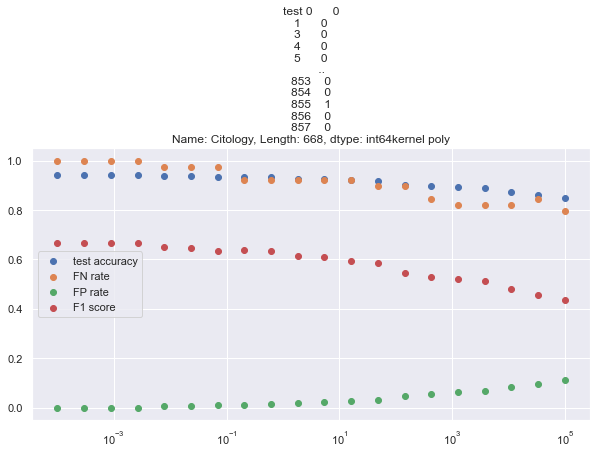

0.6666666666666666
0.058383233532934134


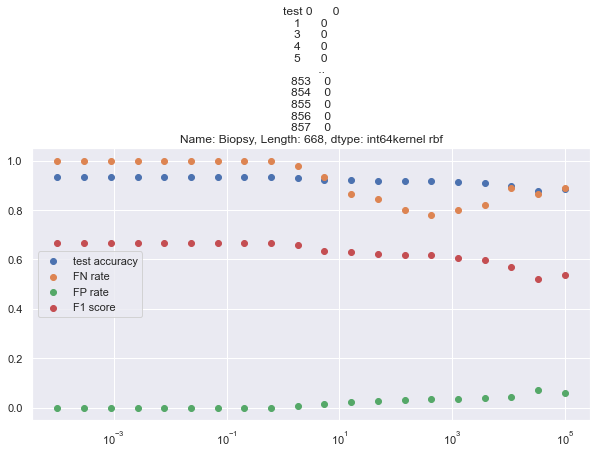

0.6666666666666666
0.06736526946107785


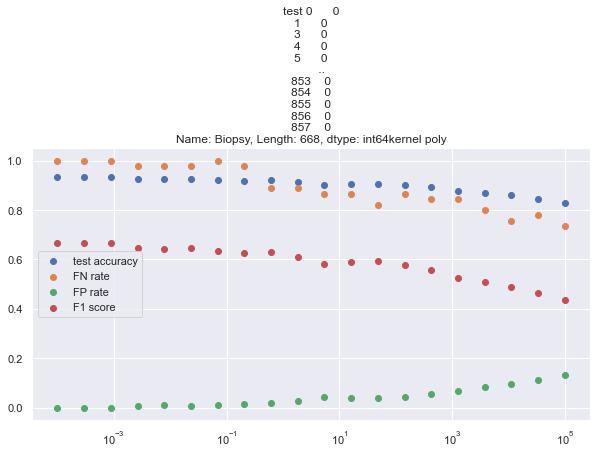

0.6666666666666666
0.06736526946107785


In [7]:
#F1 score
for a in range(4):
    for b in range(2):
        plt.figure(figsize=(10,5))
        plt.scatter(c_values,cv_data[a,b,:], label = 'test accuracy')
        plt.scatter(c_values,cv_FN[a,b,:], label = 'FN rate')
        plt.scatter(c_values,cv_FP[a,b,:], label = 'FP rate')
        plt.scatter(c_values,cv_f1[a,b,:], label = 'F1 score')
        plt.title('test ' + f'{tests[a]}' + 'kernel ' + f'{kernels_options[b]}')
        plt.xscale('log')
        plt.legend()
        plt.show()
        print(max(cv_f1[a,b,:]))
        print(max(cv_mis[a,b,:]))